### Loading the Libraries

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Importing the dataset

In [146]:
# https://stackoverflow.com/questions/57748687/downloading-files-in-jupyter-wget-on-windows
import urllib.request
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'
filename = 'AER_credit_card_data.csv'
urllib.request.urlretrieve(url, filename)

('AER_credit_card_data.csv', <http.client.HTTPMessage at 0x1fef48ced00>)

In [147]:
df = pd.read_csv('AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [148]:
df.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

### Data Preparation

In [149]:
df['target'] = (df['card'] == 'yes').astype('int')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,target
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12,1
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13,1
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5,1
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7,1
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5,1


In [150]:
# Checking if the target column has been properly mapped
print(df.card.value_counts())
print(df.target.value_counts())

yes    1023
no      296
Name: card, dtype: int64
1    1023
0     296
Name: target, dtype: int64


### Splitting the data into train, val and test 

In [151]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train.shape, df_val.shape, df_test.shape

((791, 13), (264, 13), (264, 13))

In [152]:
y_train = df_train['target'].values
y_val = df_val['target'].values
y_test = df_test['target'].values

del df_train['target']
del df_val['target']
del df_test['target']

### Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the card variable.
Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* reports
* dependents
* active
* share

In [153]:
from sklearn.metrics import auc, roc_auc_score
print(f"reports : {roc_auc_score(df_train['card'], -df_train['reports'])}")
print(f"dependents : {roc_auc_score(df_train['card'], -df_train['dependents'])}")
print(f"active : {roc_auc_score(df_train['card'], df_train['active'])}")
print(f"share : {roc_auc_score(df_train['card'], df_train['share'])}")

reports : 0.7166629860689376
dependents : 0.5327757227773791
active : 0.6043173411362006
share : 0.989183643423692


### Answer 1 - share has the higest auc score.

In [154]:
use_columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]


## Training the model
From now on, use these columns only:

["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [155]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

train_dict = df_train[use_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

### Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.615
* 0.515
* 0.715
* 0.995

In [156]:
val_dict = df_val[use_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
y_preds = model.predict(X_val)
#model.score(X_val, y_val)

round(roc_auc_score(y_val, y_pred),3)

0.995

### Answer 2 : 0.995

### Question 3
Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01.
* For each threshold, compute precision and recall.
* Plot them.
* At which threshold precision and recall curves intersect? -

    * 0.1
    * 0.3
    * 0.6
    * 0.8

In [157]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
#from sklearn.metrics import precision_recall_curve
precision_scores=[]
recall_scores = []
thresholds = np.linspace(0, 1)
for i in thresholds:
    precision = precision_score(y_val, y_pred >= i)
    recall = recall_score(y_val, y_pred >= i)
    print(f"{i.round(2)}: precision : {precision.round(3)}, recall : {recall.round(3)}")
    #print(f"{i.round(2)}: recall:{recall.round(3)}")
    precision_scores.append(precision)
    recall_scores.append(recall)


0.0: precision : 0.799, recall : 1.0
0.02: precision : 0.872, recall : 1.0
0.04: precision : 0.906, recall : 1.0
0.06: precision : 0.917, recall : 1.0
0.08: precision : 0.921, recall : 0.995
0.1: precision : 0.925, recall : 0.995
0.12: precision : 0.929, recall : 0.995
0.14: precision : 0.959, recall : 0.986
0.16: precision : 0.967, recall : 0.986
0.18: precision : 0.976, recall : 0.981
0.2: precision : 0.976, recall : 0.981
0.22: precision : 0.976, recall : 0.981
0.24: precision : 0.976, recall : 0.976
0.27: precision : 0.976, recall : 0.976
0.29: precision : 0.976, recall : 0.976
0.31: precision : 0.981, recall : 0.972
0.33: precision : 0.981, recall : 0.972
0.35: precision : 0.995, recall : 0.972
0.37: precision : 0.995, recall : 0.972
0.39: precision : 0.995, recall : 0.972
0.41: precision : 0.995, recall : 0.972
0.43: precision : 0.995, recall : 0.967
0.45: precision : 0.995, recall : 0.967
0.47: precision : 0.995, recall : 0.967
0.49: precision : 0.995, recall : 0.967
0.51: preci

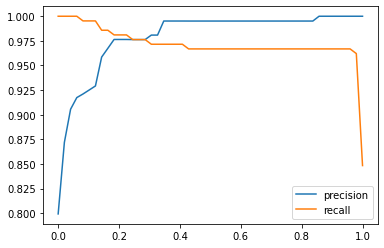

In [158]:
plt.plot(thresholds, precision_scores)
plt.plot(thresholds, recall_scores)
plt.legend(labels=['precision', 'recall'])

### Answer 3 :The precision and recall curves seem to intersect somewhere near 0.3

### Question 4
* Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

* This is the formula for computing :
     * f1 = 2 * ((P*R)/(P+R))
 

* <b>Where P = precision and R = recall.</b>

* Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

* At which threshold F1 is maximal?

    * 0.1
    * 0.4
    * 0.6
    * 0.7

In [159]:
f1 = []
thresholds = np.linspace(0, 1)
for i in thresholds:
    precision = precision_score(y_val, y_pred >= i)
    recall = recall_score(y_val, y_pred >= i)
    f1_sc = 2 * ((precision * recall) / (precision + recall))
    print(f"{i.round(2)} : f1_score : {f1_sc}")
    f1.append(f1_sc)

0.0 : f1_score : 0.8884210526315789
0.02 : f1_score : 0.9315673289183224
0.04 : f1_score : 0.9504504504504505
0.06 : f1_score : 0.9569160997732427
0.08 : f1_score : 0.9567198177676538
0.1 : f1_score : 0.958904109589041
0.12 : f1_score : 0.9610983981693364
0.14 : f1_score : 0.9719626168224299
0.16 : f1_score : 0.9765258215962441
0.18 : f1_score : 0.9787234042553191
0.2 : f1_score : 0.9787234042553191
0.22 : f1_score : 0.9787234042553191
0.24 : f1_score : 0.976303317535545
0.27 : f1_score : 0.976303317535545
0.29 : f1_score : 0.976303317535545
0.31 : f1_score : 0.9761904761904763
0.33 : f1_score : 0.9761904761904763
0.35 : f1_score : 0.9832134292565947
0.37 : f1_score : 0.9832134292565947
0.39 : f1_score : 0.9832134292565947
0.41 : f1_score : 0.9832134292565947
0.43 : f1_score : 0.9807692307692307
0.45 : f1_score : 0.9807692307692307
0.47 : f1_score : 0.9807692307692307
0.49 : f1_score : 0.9807692307692307
0.51 : f1_score : 0.9807692307692307
0.53 : f1_score : 0.9807692307692307
0.55 : f

In [160]:
thresholds = [0.1, 0.4, 0.6, 0.7]
for i in thresholds:
    precision = precision_score(y_val, y_pred >= i)
    recall = recall_score(y_val, y_pred >= i)
    f1_sc = 2 * ((precision * recall) / (precision + recall))
    print(f"{i} : f1_score : {f1_sc}")
    

0.1 : f1_score : 0.958904109589041
0.4 : f1_score : 0.9832134292565947
0.6 : f1_score : 0.9807692307692307
0.7 : f1_score : 0.9807692307692307


### Answer 4 - The f1 score is maximum around 0.4

### Question 5
* Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

* KFold(n_splits=5, shuffle=True, random_state=1)
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation
* How large is standard devidation of the AUC scores across different folds?

    * 0.003
    * 0.014
    * 0.09
    * 0.24

In [162]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train['target'].values
    y_val = df_val['target'].values
    
    del df_train['target']
    del df_val['target']
    
    dv_k = DictVectorizer(sparse=False)
    train_dict = df_train[use_columns].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    val_dict = df_val[use_columns].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    model_k = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_k.fit(X_train, y_train)
    
    y_pred = model_k.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append(auc)

print(np.mean(scores).round(3), np.std(scores).round(3))

0.996 0.003


In [164]:
from tqdm.auto import tqdm

### Answer 5 : The standard deviation is 0.03 across different folds.

### Question 6
* Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 1, 10]
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: <b>LogisticRegression(solver='liblinear', C=C, max_iter=1000)</b>
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
* Which C leads to the best mean score?

    * 0.01
    * 0.1
    * 1
    * 10

* If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [166]:
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['target'].values
        y_val = df_val['target'].values
    
        del df_train['target']
        del df_val['target']
    
        dv_k = DictVectorizer(sparse=False)
        train_dict = df_train[use_columns].to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)
    
        val_dict = df_val[use_columns].to_dict(orient='records')
        X_val = dv.transform(val_dict)
    
        model_k = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
        model_k.fit(X_train, y_train)
    
        y_pred = model_k.predict_proba(X_val)[:, 1]
    
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append(auc)


    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.996 +- 0.003
C=0.1 0.996 +- 0.003
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003


### Answer 6 - We have ties for both standard deviation and mean. Hence we choose the score with lowest C value i.e. 0.01.